In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#changing the working directory
%cd /content/drive/My Drive/DS-Project/

/content/drive/My Drive/DS-Project


In [3]:
# basic libraries
import pandas as pd
import string
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
%matplotlib inline

# text preprocessing and modelling
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from tqdm import tqdm
import pickle

# import nltk library and VADER (Valence Aware Dictionary for sEntiment Reasoning)
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Sentiment Analysis on Reviews Posts

### Raw Dataset

In [ ]:
# import reviews datasets
#jomalone_df = pd.read_csv("JoMalone_data.csv")
#target_df = pd.read_csv("Target_data.csv")
walmart_df_one = pd.read_csv("Walmart_data.csv")
walmart_df_two = pd.read_csv("walmart_new.csv")
walmart_df_three = pd.read_csv("walmart_two.csv")

In [ ]:
# stack the reviews DataFrames
#review_df = pd.concat([jomalone_df, target_df, walmart_df_one, walmart_df_two, walmart_df_three], ignore_index = True)
review_df = pd.concat([walmart_df_one, walmart_df_two, walmart_df_three], ignore_index = True)
# rename column
review_df = review_df.rename(columns = {'caption':'text'})
# drop first column
review_df = review_df.drop(columns=['Unnamed: 0'])
# drop duplicates
review_df = review_df.drop_duplicates(subset=['text'])
review_df

,text
0,Dedicated trading platform my whole experience...
1,Absolutely horrible customer service. No help ...
2,HORRIBLE Horrible delivery service. Yada yada ...
3,Horrible company! Arresting people for buying ...
4,If you are going to charge $98 for a delivery ...
...,...
20008,"After speaking with the assistant manager, she..."
20009,I almost lost my mind at Walmart last night!!!...
20010,Wal-Mart had an after Thanksgiving sale that w...
20011,The manager was very rude and treated us like ...


In [ ]:
# check if dataframe contain null values
review_df.isnull().sum()

text    0
dtype: int64

a positive sentiment, compound ≥ 0.05
a negative sentiment, compound ≤ -0.05
a neutral sentiment, the compound is between ]-0.05, 0.05[
  
Refer source: https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fsocial-media-sentiment-analysis-in-python-with-vader-no-training-required-4bc6a21e87b8

In [ ]:
# determine sentiment polarity group
# paramater x is sentiment score 
def polarity(x):
  if x > 0.05: 
    return 'positive'
  elif x < -0.05:
    return 'negative'
  else:
    return 'neutral'

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [ ]:
# Create new column 'scores' to store polarity scores
review_df['text'] = review_df['text'].astype(str)
review_df['scores'] = review_df['text'].apply(lambda review: sid.polarity_scores(review))
# Extract the scores into four columns - neg, neu, pos, compund
review_df = pd.concat([review_df.drop(['scores'], axis=1), review_df['scores'].apply(pd.Series)], axis=1)

# Create new column 'compound' to store compound scores
# review_df['compound_score']  = review_df['scores'].apply(lambda score_dict: score_dict['compound'])

# Create new column to store the polarity label
review_df['sentiment'] = review_df['compound'].apply(polarity)

review_df

,text,neg,neu,pos,compound,sentiment
0,Dedicated trading platform my whole experience...,0.000,0.707,0.293,0.9603,positive
1,Absolutely horrible customer service. No help ...,0.265,0.563,0.172,-0.4201,negative
2,HORRIBLE Horrible delivery service. Yada yada ...,0.218,0.706,0.076,-0.7213,negative
3,Horrible company! Arresting people for buying ...,0.310,0.690,0.000,-0.9304,negative
4,If you are going to charge $98 for a delivery ...,0.101,0.749,0.151,0.2232,positive
...,...,...,...,...,...,...
20008,"After speaking with the assistant manager, she...",0.032,0.953,0.014,-0.2960,negative
20009,I almost lost my mind at Walmart last night!!!...,0.144,0.801,0.055,-0.9126,negative
20010,Wal-Mart had an after Thanksgiving sale that w...,0.136,0.808,0.056,-0.7579,negative
20011,The manager was very rude and treated us like ...,0.262,0.679,0.059,-0.8265,negative


In [ ]:
# save new file as csv to save time
review_df.to_csv('review_sentiment_scores.csv', index=False)

### Import dataset with label

In [ ]:
# read csv file
review_df_1 = pd.read_csv('review_sentiment_scores.csv', encoding='latin-1')

review_df_1

,text,neg,neu,pos,compound,sentiment
0,Dedicated trading platform my whole experience...,0.000,0.707,0.293,0.9603,positive
1,Absolutely horrible customer service. No help ...,0.265,0.563,0.172,-0.4201,negative
2,HORRIBLE Horrible delivery service. Yada yada ...,0.218,0.706,0.076,-0.7213,negative
3,Horrible company! Arresting people for buying ...,0.310,0.690,0.000,-0.9304,negative
4,If you are going to charge $98 for a delivery ...,0.101,0.749,0.151,0.2232,positive
...,...,...,...,...,...,...
15403,"After speaking with the assistant manager, she...",0.032,0.953,0.014,-0.2960,negative
15404,I almost lost my mind at Walmart last night!!!...,0.144,0.801,0.055,-0.9126,negative
15405,Wal-Mart had an after Thanksgiving sale that w...,0.136,0.808,0.056,-0.7579,negative
15406,The manager was very rude and treated us like ...,0.262,0.679,0.059,-0.8265,negative


### EDA

In [ ]:
# show sentiment count in bar chart using pyplot
count = review_df_1.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
df_group = review_df_1['sentiment'].value_counts(normalize=True).rename_axis("Sentiment").reset_index(name="Percentage")
df_group['Percentage'] = df_group.Percentage.apply(lambda x: x*100)

fig = go.Figure(go.Bar(
    x=count.sentiment, y=count.text, text=df_group.Percentage.apply(lambda x: '{0:1.2f}%'.format(x))
    ))
fig.show()

In [ ]:
# Funnel-Chart 
funnel = review_df_1.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
fig = go.Figure(go.Funnelarea(
    text = funnel.sentiment,
    values = funnel.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
# categorise the text based on positive and negative
review_pos = review_df_1[review_df_1['sentiment'] == 'positive']
review_neu = review_df_1[review_df_1['sentiment'] == 'neutral']
review_neg = review_df_1[review_df_1['sentiment'] == 'negative']

In [ ]:
pos_downsample = resample(review_pos,
             replace=True,
             n_samples=5603,
             random_state=42)

print(pos_downsample.shape)

(5603, 6)


In [ ]:
neg_downsample = resample(review_neg,
             replace=True,
             n_samples=4850,
             random_state=42)

print(neg_downsample.shape)

(4850, 6)


In [ ]:
neutral_reviews = pd.read_csv('neutral reviews.csv', encoding='latin-1')
neu_upsample = pd.concat([review_neu, neutral_reviews])
print(neu_upsample.shape)

(2175, 6)


In [ ]:
neu_upsample = resample(neu_upsample,
             replace=True,
             n_samples=3175,
             random_state=42)

print(neu_upsample.shape)

(3175, 6)


In [ ]:
review_df_1 = pd.concat([pos_downsample, neg_downsample, neu_upsample], ignore_index=True)
review_df_1

,text,neg,neu,pos,compound,sentiment
0,"Yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah...",0.000,0.467,0.533,0.9817,positive
1,They don't have enough check outs. Sometimes t...,0.000,0.756,0.244,0.8408,positive
2,My complaint is you are replacing all brand na...,0.046,0.735,0.219,0.9485,positive
3,I think everyone should be very excited to hav...,0.000,0.920,0.080,0.4005,positive
4,I went through a lot of trouble to ensure that...,0.042,0.867,0.091,0.7884,positive
...,...,...,...,...,...,...
13623,"I was not overly impressed by this product, bu...",0.000,1.000,0.000,0.0000,neutral
13624,The items added up to 120.00 and had to be lef...,0.056,0.888,0.055,-0.0202,neutral
13625,I was neither impressed nor disappointed by th...,0.000,1.000,0.000,0.0000,neutral
13626,Hour and a half for a simple oil change and ST...,0.000,1.000,0.000,0.0000,neutral


In [ ]:
# show sentiment count in bar chart using pyplot
count = review_df_1.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
df_group = review_df_1['sentiment'].value_counts(normalize=True).rename_axis("Sentiment").reset_index(name="Percentage")
df_group['Percentage'] = df_group.Percentage.apply(lambda x: x*100)

fig = go.Figure(go.Bar(
    x=count.sentiment, y=count.text, text=df_group.Percentage.apply(lambda x: '{0:1.2f}%'.format(x))
    ))
fig.update_traces(textposition='outside')
fig.update_layout(
    width=500,
)
fig.show()

In [ ]:
# highest positive sentiment reviews
temp_pos = review_df_1.drop_duplicates('text')
temp_pos.sort_values("pos", ascending = False)[["text", "pos"]].head(10)

,text,pos
178,Top favorite store,0.828
5058,Love everything,0.808
5300,Great experience,0.804
1168,Great price,0.804
1764,Awesome experience.,0.804
318,Excellent quality!,0.800
1639,it's excellent and amazing,0.789
54,Excellent side,0.787
2200,Excellent service,0.787
2114,Excellent experience.,0.787


In [ ]:
# lowest negative sentiment reviews
temp_neg = review_df_1.drop_duplicates('text')
temp_neg.sort_values("neg", ascending = False)[["text", "neg"]].head(10)

,text,neg
7180,No problems!,1.000
7299,"Bad site, bad company, bad experiences, just bad",0.778
8053,BAD LIMA BEANS!,0.655
8209,Frustration and stress and hours of wasted time,0.645
5885,Good no complaints,0.628
9904,Received a wrong product,0.608
7353,Horrible. Don't care about their customers.,0.605
6205,Tip for consumers:\nBad service bad attitude,0.583
6656,Short pump store is horrible dirty people rude...,0.556
6602,"No damage to me ,but I feel cheated and stole ...",0.538


### Text preprocessing

#### abbreviations

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

#### Removal and processing words

In [ ]:
# Remove all english stopwords
def remove_stopwords(text):
    stop_words = stopwords.words("english")
    custom_stop_words = ['walmart', 'wal', 'mart', 'walmartcom']
    omit_stop_words = ['not', 'nor', 'but']
    stop_words.extend(custom_stop_words)
    stop_words = [el for el in stop_words if el not in omit_stop_words]
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)       

# Remove numbers
def remove_number(text):
    return re.sub(r'\d+', '', text)

# Remove emoji
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

"""from emot.emo_unicode import UNICODE_EMO, EMOTICONS
# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        return text

# Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        return text
"""
# lemmatize text (convert to root form of text)
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [ ]:
def clean_text(text):
    # lowercase text and remove punctuation
    text = text.lower()
    text = remove_all_punct(text)
    # Remove non text (url, html tag, non ASCII characters)
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    # replace abbreviations, remove mention, remove emoji, remove number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_emoji(text)
    text = remove_number(text)
    # Remove stopwords and lemmatize text
    text = remove_stopwords(text)
    text = lemmatization(text)

    return text

In [ ]:
review_df_1["clean_text"] = review_df_1["text"].apply(clean_text)
review_df_1

,text,neg,neu,pos,compound,sentiment,clean_text
0,"Yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah...",0.000,0.467,0.533,0.9817,positive,yeah yeah yeah yeah yeah yeah yeah yeah yeah i...
1,They don't have enough check outs. Sometimes t...,0.000,0.756,0.244,0.8408,positive,dont enough check out sometimes supply need ov...
2,My complaint is you are replacing all brand na...,0.046,0.735,0.219,0.9485,positive,complaint replace brand name products great va...
3,I think everyone should be very excited to hav...,0.000,0.920,0.080,0.4005,positive,think everyone excite job world today without ...
4,I went through a lot of trouble to ensure that...,0.042,0.867,0.091,0.7884,positive,go lot trouble ensure pay online order happy r...
...,...,...,...,...,...,...,...
13623,"I was not overly impressed by this product, bu...",0.000,1.000,0.000,0.0000,neutral,not overly impress product but meet expectations
13624,The items added up to 120.00 and had to be lef...,0.056,0.888,0.055,-0.0202,neutral,items add leave behind items need tomorrow mot...
13625,I was neither impressed nor disappointed by th...,0.000,1.000,0.000,0.0000,neutral,neither impress nor disappoint product expect
13626,Hour and a half for a simple oil change and ST...,0.000,1.000,0.000,0.0000,neutral,hour half simple oil change still wait car car...


In [ ]:
# save new file as csv to save time
review_df_1.to_csv('review_clean.csv', index=False)

### Word Cloud (EDA)

In [ ]:
# categorise the text based on positive and negative
review_pos = review_df_1[review_df_1['sentiment'] == 'positive']
review_pos = review_pos['clean_text']
review_neu = review_df_1[review_df_1['sentiment'] == 'neutral']
review_neu = review_neu['clean_text']
review_neg = review_df_1[review_df_1['sentiment'] == 'negative']
review_neg = review_neg['clean_text']

Positive words


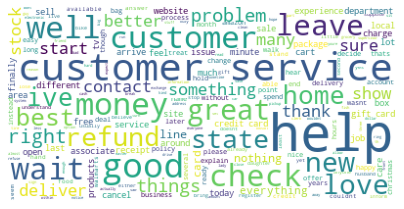

Neutral words


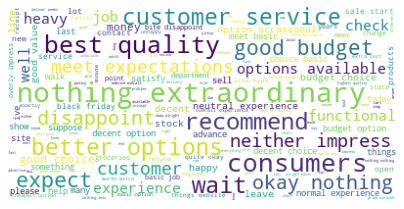

Negative words


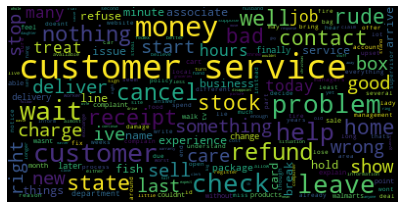

In [ ]:
# generate word cloud
def wordcloud_draw(data, color = 'black'):
    cleaned_word = " ".join(data)
    stop_words = list(STOPWORDS)
    custom_stop_words = ['store', 'time', 'make', 'one', 'say', 'tell', 'item', 'us', 'employees',
                         'order', 'come', 'take', 'got', 'never', 'dont', 'didnt', 'way',
                         'product', 'need', 'people', 'go', 'now', 'back', 'pick', 'use', 'really',
                         'day','ask', 'know', 'tip', 'purchase', 'call', 'try', 'still', 'email',
                         'look', 'buy', 'items', 'employee', 'product', 'price', 'pay', 'cashier',
                         'want' , 'thing', 'work', 'walmartcom', 'im', 'see', 'give', 'someone',
                         'even', 'always', 'consumer', 'place', 'shop', 'think', 'manager', 'return',
                         'another', 'put', 'phone', 'person', 'ship', 'company', 'online', 'next', 'let',
                         'first', 'speak', 'number', 'cant', 'anything', 'two', 'every', 'happen', 'send',
                         'talk', 'find', 'keep', 'days', 'receive', 'year', 'week', 'hour']
    stop_words = set(stop_words + custom_stop_words)
    wordcloud = WordCloud(stopwords=stop_words,
                      background_color=color,
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(7, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(review_pos,'white')
print("Neutral words")
wordcloud_draw(review_neu,'white')
print("Negative words")
wordcloud_draw(review_neg)

## N-grams

In [4]:
def get_ngrams(text, ngram_from, ngram_to, n=None):
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

In [ ]:
# categorise the text based on positive and negative
review_pos = review_df_1[review_df_1['sentiment'] == 'positive']
review_neu = review_df_1[review_df_1['sentiment'] == 'neutral']
review_neg = review_df_1[review_df_1['sentiment'] == 'negative']

### n-grams without category



In [12]:
# read csv files
review_df_1 = pd.read_csv('review_clean.csv')

# convert text to string
review_df_1['clean_text'] = review_df_1['clean_text'].astype('str') 

# Remove all english stopwords
def remove_stopwords(text):
    custom_stop_words = ['store', 'time', 'make', 'one', 'say', 'tell', 'item', 'us', 'employees',
                         'order', 'come', 'take', 'got', 'never', 'dont', 'didnt', 'way', 'would',
                         'product', 'need', 'people', 'go', 'now', 'back', 'pick', 'use', 'really',
                         'day','ask', 'know', 'tip', 'purchase', 'call', 'try', 'still', 'email',
                         'look', 'buy', 'items', 'employee', 'product', 'price', 'pay', 'cashier',
                         'want' , 'thing', 'work', 'walmartcom', 'im', 'see', 'give', 'someone',
                         'even', 'always', 'consumer', 'place', 'shop', 'think', 'manager', 'return',
                         'another', 'put', 'phone', 'person', 'ship', 'company', 'online', 'next', 'let',
                         'first', 'speak', 'number', 'cant', 'anything', 'two', 'every', 'happen', 'send',
                         'talk', 'find', 'keep', 'days', 'receive', 'year', 'week', 'hour', 'could']
    text = ' '.join([word for word in text.split() if word not in custom_stop_words])
    return text

def clean_stopwords(text):
  # Remove stopwords and lemmatize text
  text = remove_stopwords(text)
  return text

review_df_1["clean_text_temp"] = review_df_1["clean_text"].apply(clean_stopwords)
review_df_1

,text,neg,neu,pos,compound,sentiment,clean_text,clean_text_temp
0,"Yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah...",0.000,0.467,0.533,0.9817,positive,yeah yeah yeah yeah yeah yeah yeah yeah yeah i...,yeah yeah yeah yeah yeah yeah yeah yeah yeah m...
1,They don't have enough check outs. Sometimes t...,0.000,0.756,0.244,0.8408,positive,dont enough check out sometimes supply need ov...,enough check out sometimes supply overall good...
2,My complaint is you are replacing all brand na...,0.046,0.735,0.219,0.9485,positive,complaint replace brand name products great va...,complaint replace brand name products great va...
3,I think everyone should be very excited to hav...,0.000,0.920,0.080,0.4005,positive,think everyone excite job world today without ...,everyone excite job world today without custom...
4,I went through a lot of trouble to ensure that...,0.042,0.867,0.091,0.7884,positive,go lot trouble ensure pay online order happy r...,lot trouble ensure happy new extra get fast de...
...,...,...,...,...,...,...,...,...
13623,"I was not overly impressed by this product, bu...",0.000,1.000,0.000,0.0000,neutral,not overly impress product but meet expectations,not overly impress but meet expectations
13624,The items added up to 120.00 and had to be lef...,0.056,0.888,0.055,-0.0202,neutral,items add leave behind items need tomorrow mot...,add leave behind tomorrow mother owner card ca...
13625,I was neither impressed nor disappointed by th...,0.000,1.000,0.000,0.0000,neutral,neither impress nor disappoint product expect,neither impress nor disappoint expect
13626,Hour and a half for a simple oil change and ST...,0.000,1.000,0.000,0.0000,neutral,hour half simple oil change still wait car car...,half simple oil change wait car car auto cente...


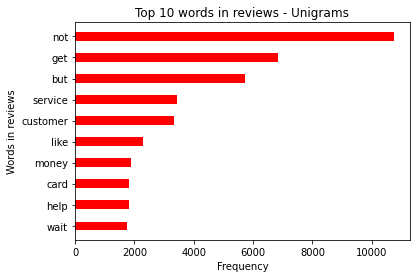

In [13]:
# get unigrams
unigrams_df = pd.DataFrame(get_ngrams(review_df_1['clean_text_temp'], ngram_from=1, ngram_to=1, n=15))
unigrams_df.columns=["Unigram", "Frequency"]
unigrams_df = unigrams_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Unigram","Frequency", color ='red',
        height = 0.4, data=unigrams_df)
plt.xlabel("Frequency")
plt.ylabel("Words in reviews")
plt.title("Top 10 words in reviews - Unigrams")
plt.show()

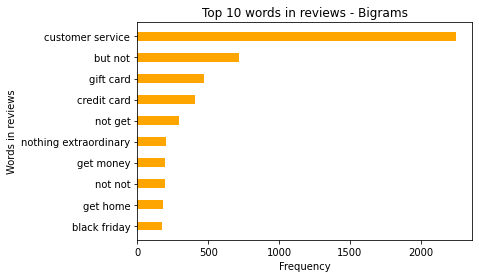

In [17]:
# get bigrams
bigrams_df = pd.DataFrame(get_ngrams(review_df_1['clean_text_temp'], ngram_from=2, ngram_to=2, n=15))
bigrams_df.columns=["Bigram", "Frequency"]
bigrams_df = bigrams_df.drop(5)
bigrams_df = bigrams_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Bigram","Frequency", color ='orange',
        height = 0.4, data=bigrams_df)
plt.xlabel("Frequency")
plt.ylabel("Words in reviews")
plt.title("Top 10 words in reviews - Bigrams")
plt.show()

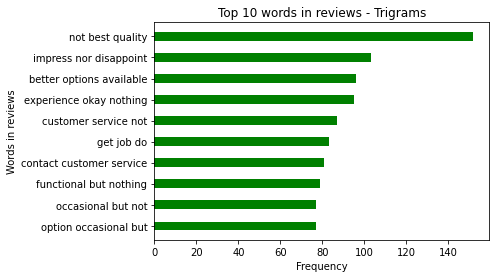

In [27]:
# get trigrams
trigrams_df = pd.DataFrame(get_ngrams(review_df_1['clean_text_temp'], ngram_from=3, ngram_to=3, n=15))
trigrams_df.columns=["Trigram", "Frequency"]
trigrams_df = trigrams_df.drop(1)
trigrams_df = trigrams_df.drop(2)
trigrams_df = trigrams_df.drop(3)
trigrams_df = trigrams_df.drop(5)
trigrams_df = trigrams_df.drop(6)
trigrams_df = trigrams_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Trigram","Frequency", color ='green',
        height = 0.4, data=trigrams_df)
plt.xlabel("Frequency")
plt.ylabel("Words in reviews")
plt.title("Top 10 words in reviews - Trigrams")
plt.show()

### positive words n-grams

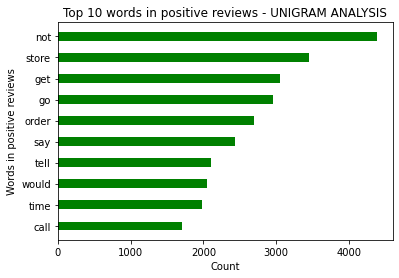

In [ ]:
# get unigrams
unigrams_pos_df = pd.DataFrame(get_ngrams(review_pos['clean_text'], ngram_from=1, ngram_to=1, n=15))
unigrams_pos_df.columns=["Unigram", "Frequency"]
unigrams_pos_df = unigrams_pos_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Unigram","Frequency", color ='green',
        height = 0.4, data=unigrams_pos_df)
plt.xlabel("Count")
plt.ylabel("Words in positive reviews")
plt.title("Top 10 words in positive reviews - UNIGRAM ANALYSIS")
plt.show()

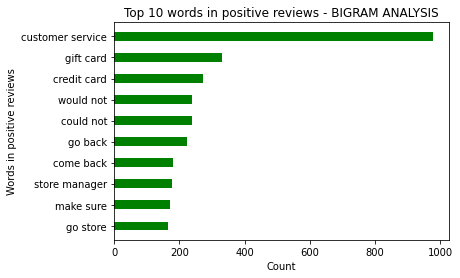

In [ ]:
# get bigrams
bigrams_pos_df = pd.DataFrame(get_ngrams(review_pos['clean_text'], ngram_from=2, ngram_to=2, n=15))
bigrams_pos_df.columns=["Bigram", "Frequency"]
bigrams_pos_df = bigrams_pos_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Bigram","Frequency", color ='green',
        height = 0.4, data=bigrams_pos_df)
plt.xlabel("Count")
plt.ylabel("Words in positive reviews")
plt.title("Top 10 words in positive reviews - BIGRAM ANALYSIS")
plt.show()

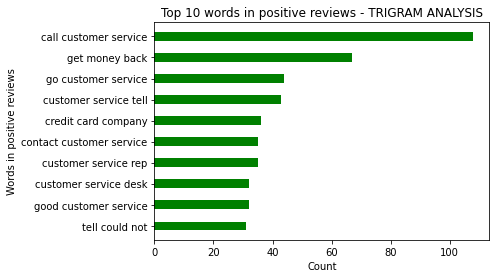

In [ ]:
# get trigrams
trigrams_pos_df = pd.DataFrame(get_ngrams(review_pos['clean_text'], ngram_from=3, ngram_to=3, n=15))
trigrams_pos_df.columns=["Trigram", "Frequency"]
#trigrams_pos_df = trigrams_pos_df.iloc[2:]
trigrams_pos_df = trigrams_pos_df.drop(5)
trigrams_pos_df = trigrams_pos_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Trigram","Frequency", color ='green',
        height = 0.4, data=trigrams_pos_df)
plt.xlabel("Count")
plt.ylabel("Words in positive reviews")
plt.title("Top 10 words in positive reviews - TRIGRAM ANALYSIS")
plt.show()

### Negative words n-grams

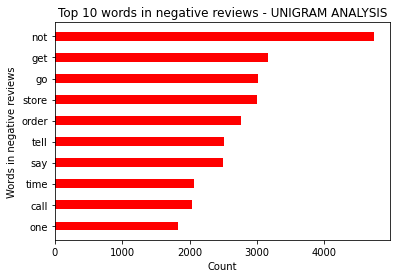

In [ ]:
# get unigrams
unigrams_neg_df = pd.DataFrame(get_ngrams(review_neg['clean_text'], ngram_from=1, ngram_to=1, n=15))
unigrams_neg_df.columns=["Unigram", "Frequency"]
unigrams_neg_df = unigrams_neg_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Unigram","Frequency", color ='red',
        height = 0.4, data=unigrams_neg_df)
plt.xlabel("Count")
plt.ylabel("Words in negative reviews")
plt.title("Top 10 words in negative reviews - UNIGRAM ANALYSIS")
plt.show()

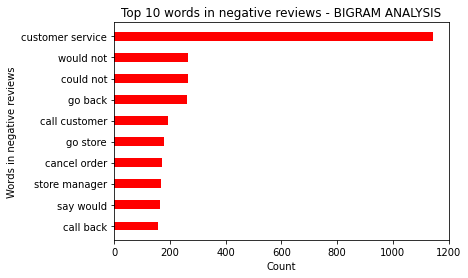

In [ ]:
# get bigrams
bigrams_neg_df = pd.DataFrame(get_ngrams(review_neg['clean_text'], ngram_from=2, ngram_to=2, n=15))
bigrams_neg_df.columns=["Bigram", "Frequency"]
bigrams_neg_df = bigrams_neg_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Bigram","Frequency", color ='red',
        height = 0.4, data=bigrams_neg_df)
plt.xlabel("Count")
plt.ylabel("Words in negative reviews")
plt.title("Top 10 words in negative reviews - BIGRAM ANALYSIS")
plt.show()

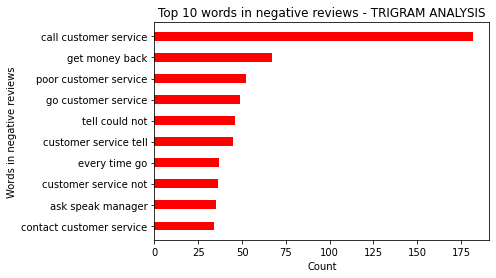

In [ ]:
# get trigrams
trigrams_neg_df = pd.DataFrame(get_ngrams(review_neg['clean_text'], ngram_from=3, ngram_to=3, n=15))
trigrams_neg_df.columns=["Trigram", "Frequency"]
trigrams_neg_df = trigrams_neg_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Trigram","Frequency", color ='red',
        height = 0.4, data=trigrams_neg_df)
plt.xlabel("Count")
plt.ylabel("Words in negative reviews")
plt.title("Top 10 words in negative reviews - TRIGRAM ANALYSIS")
plt.show()

### Neutral words n-grams

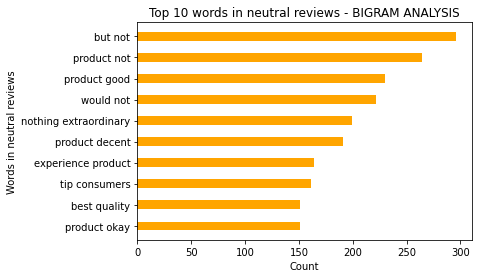

In [ ]:
# get bigrams
bigrams_neu_df = pd.DataFrame(get_ngrams(review_neu['clean_text'], ngram_from=2, ngram_to=2, n=15))
bigrams_neu_df.columns=["Bigram", "Frequency"]
bigrams_neu_df = bigrams_neu_df.drop(9)
bigrams_neu_df = bigrams_neu_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Bigram","Frequency",color ='orange',
        height = 0.4, data=bigrams_neu_df)
plt.xlabel("Count")
plt.ylabel("Words in neutral reviews")
plt.title("Top 10 words in neutral reviews - BIGRAM ANALYSIS")
plt.show()

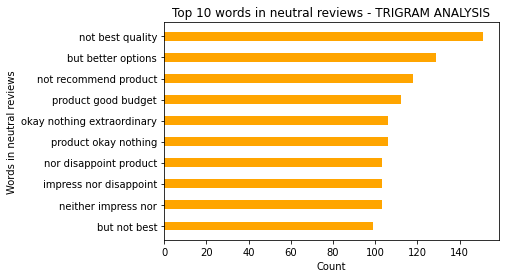

In [ ]:
# get trigrams
trigrams_neu_df = pd.DataFrame(get_ngrams(review_neu['clean_text'], ngram_from=3, ngram_to=3, n=15))
trigrams_neu_df.columns=["Trigram", "Frequency"]
trigrams_neu_df = trigrams_neu_df.drop(2)
trigrams_neu_df = trigrams_neu_df.head(10).sort_values(by='Frequency', ascending=True)

plt.barh("Trigram","Frequency", color ='orange',
        height = 0.4, data=trigrams_neu_df)
plt.xlabel("Count")
plt.ylabel("Words in neutral reviews")
plt.title("Top 10 words in neutral reviews - TRIGRAM ANALYSIS")
plt.show()

## Train-test split

In [ ]:
# read csv files
review_data = pd.read_csv('review_clean.csv')

# convert text to string
review_data['clean_text'] = review_data['clean_text'].astype('str') 

In [ ]:
# Split into training and test set
X = review_data['clean_text']
Y = review_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (10902,)
y_train: (10902,)
X_test: (2726,)
y_test: (2726,)


## Bags of words model

In [ ]:
# initialize tokenizer
def tok(text):
  tt = TweetTokenizer()
  return tt.tokenize(text)

#Count vectorizer for bag of words
cv = CountVectorizer(tokenizer=tok)
#transformed train reviews
cv_train_reviews = cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews = cv.transform(X_test)

## Term frequency–inverse document frequency (Tf-IDF)

In [ ]:
# initialize Tfidf vectorizer along with Tokenizer 
tv = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize)
#tv = TfidfVectorizer(tokenizer=word_tokenize)
#transformed train reviews
tv_train_reviews = tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews = tv.transform(X_test)

## Modelling

Train model with count vectorizer data

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
# Multinomial Naive Bayes
mnb = MultinomialNB()
# K-Neearest Neighbour
#knn = KNeighborsClassifier()
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
# Support Vector Machine (classification)
svm_svc = svm.SVC(random_state=42)
# Stochastic gradient descent 
sgd = SGDClassifier(random_state=42)

model_list = [lr, mnb, dtc, rfc, svm_svc, sgd]
model_name = ['Logistic Regression', 'Multinomial Naive Bayes', 'Decision Tree',
              'Random Forest', 'Support Vector Machine', 'Stochastic Gradient Descent']
score_list = []
results_cv = pd.DataFrame()

for model in tqdm(model_list):
  model.fit(cv_train_reviews, y_train)
  y_pred = model.predict(cv_test_reviews)
  accuracy = accuracy_score(y_test, y_pred)
  score_list.append(accuracy)

results_cv['Model'] = pd.DataFrame(model_name) 
results_cv['Accuracy'] = pd.DataFrame(score_list) 

100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


In [ ]:
# accuracy score for trained model with count vectorizer data (newest)
results_cv.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
5,Stochastic Gradient Descent,0.867938
0,Logistic Regression,0.863903
3,Random Forest,0.863536
4,Support Vector Machine,0.814380
2,Decision Tree,0.808144
1,Multinomial Naive Bayes,0.739545


Train model with tfidf data

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
# Multinomial Naive Bayes
mnb = MultinomialNB()
# K-Neearest Neighbour
#knn = KNeighborsClassifier()
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
# Support Vector Machine (classification)
svm_svc = svm.SVC(random_state=42)
# Stochastic gradient descent 
sgd = SGDClassifier(random_state=42)

model_list = [lr, mnb, dtc, rfc, svm_svc, sgd]
model_name = ['Logistic Regression', 'Multinomial Naive Bayes', 'Decision Tree',
              'Random Forest', 'Support Vector Machine', 'Stochastic Gradient Descent']
score_list = []
results_tfidf = pd.DataFrame()

for model in tqdm(model_list):
  model.fit(tv_train_reviews, y_train)
  y_pred = model.predict(tv_test_reviews)
  accuracy = accuracy_score(y_test, y_pred)
  score_list.append(accuracy)

results_tfidf['Model'] = pd.DataFrame(model_name) 
results_tfidf['Accuracy'] = pd.DataFrame(score_list) 

100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


In [ ]:
# accuracy score for trained model with tfidf data (newest)
results_tfidf.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
4,Support Vector Machine,0.873441
3,Random Forest,0.859868
5,Stochastic Gradient Descent,0.822450
0,Logistic Regression,0.807777
2,Decision Tree,0.797506
1,Multinomial Naive Bayes,0.680484


### LSTM 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

#Generating Embeddings using tokenizer
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(review_data['clean_text'])
X = tokenizer.texts_to_sequences(review_data['clean_text'])
X = pad_sequences(X)
print("Total distinct words:", len(tokenizer.word_index))
# Transforming Target Label
Y = pd.get_dummies(review_data['sentiment'],columns=review_data["sentiment"])
lb = LabelBinarizer().fit_transform(review_data['sentiment'])

Total distinct words: 14128


In [ ]:
#Model Building
model = Sequential()
model.add(Embedding(14128, 128, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2230, 128)         1808384   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2230, 128)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 2,063,775
Trainable params: 2,063,775
Non-trainable params: 0
_________________________________________________________________
None


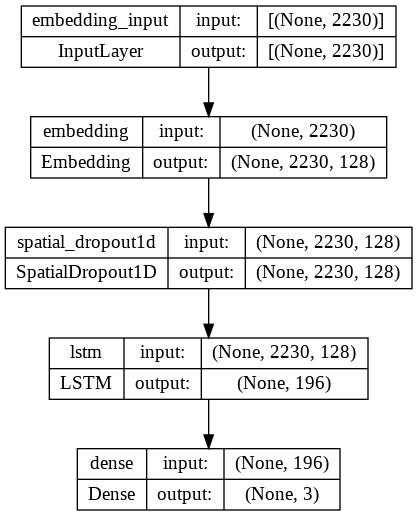

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
#y_train = LabelBinarizer().fit_transform(y_train)
#y_test = LabelBinarizer().fit_transform(y_test)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(10902, 2230) (10902, 3)
(2726, 2230) (2726, 3)


In [ ]:
# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/10
327/327 [==============================] - 4590s 14s/step - loss: 0.7565 - accuracy: 0.6423 - val_loss: 0.6433 - val_accuracy: 0.7180
Epoch 2/10
327/327 [==============================] - 4623s 14s/step - loss: 0.5136 - accuracy: 0.7929 - val_loss: 0.5920 - val_accuracy: 0.7563
Epoch 3/10
327/327 [==============================] - 4627s 14s/step - loss: 0.4018 - accuracy: 0.8516 - val_loss: 0.6392 - val_accuracy: 0.7479
Epoch 4/10
327/327 [==============================] - 4660s 14s/step - loss: 0.3221 - accuracy: 0.8857 - val_loss: 0.6720 - val_accuracy: 0.7579
Epoch 5/10
327/327 [==============================] - 4632s 14s/step - loss: 0.2557 - accuracy: 0.9126 - val_loss: 0.7743 - val_accuracy: 0.7525
Epoch 6/10
327/327 [==============================] - 4660s 14s/step - loss: 0.2080 - accuracy: 0.9303 - val_loss: 0.7832 - val_accuracy: 0.7452
Epoch 7/10
327/327 [==============================] - 4627s 14s/step - loss: 0.1877 - accuracy: 0.9370 - val_loss: 0.9005 - val_ac

In [ ]:
#new
history_plot = pd.DataFrame(model.history.history)
history_plot[['accuracy', 'val_accuracy']].plot()
history_plot[['loss', 'val_loss']].plot()

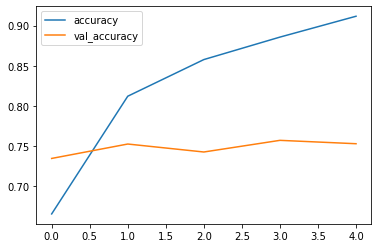

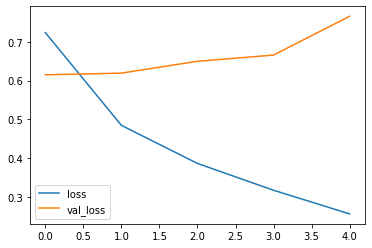

In [ ]:
history_plot = pd.DataFrame(model.history.history)
history_plot[['accuracy', 'val_accuracy']].plot()
history_plot[['loss', 'val_loss']].plot()

In [ ]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
# save the LSTM model
save_model(model,'lstm_model.h5')
#save_model(history,'lstm_model.h5')
# load model
#lstm_model = load_model('lstm_model.h5')

In [ ]:
#Model Testing
model.evaluate(X_test, y_test)

## Hyperparameter Tuning

### Support Vector Machine

In [ ]:
model_svm = svm.SVC(random_state = 42)
# define evaluation
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
# define search space
param_grid = dict()
param_grid['C'] = [0.01, 0.1, 1, 5, 10, 100, 1000]
param_grid['gamma'] = [1, 0.1, 0.001, 0.0001]
param_grid['kernel'] = ['linear', 'rbf', 'poly', 'sigmoid']
# define search
search = GridSearchCV(model_svm, param_grid, refit=True, verbose=2)
# execute search
result = search.fit(tv_train_reviews, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print how our model looks after hyper-parameter tuning
print(result.best_estimator_)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=  43.0s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=  45.1s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=  43.4s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=  42.2s
[CV] END .....................C=0.01, gamma=1, kernel=linear; total time=  44.9s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  47.1s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  49.7s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  47.4s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  46.7s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  47.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=  45.0s
[CV] END .......................C=0.01, gamma=

Best Hyperparameters: {'C': 5, 'gamma': 1, 'kernel': 'rbf'}

SVC(C=5, gamma=1, random_state=42)

## Model Evaluation

In [ ]:
# ngram 1,1
#training the model with best parameters
model = svm.SVC(C=5, gamma=1, kernel='rbf', random_state=42, probability=True)

#Fitting the model for tfidf data
model = model.fit(tv_train_reviews, y_train)

#Predicting the model for tfidf data
model_predict = model.predict(tv_test_reviews)

# Classification report token (new with stopword removal)
lr_report = classification_report(y_test, model_predict, target_names=model.classes_)
print(lr_report)

              precision    recall  f1-score   support

    negative       0.84      0.87      0.86       964
     neutral       0.99      0.92      0.95       633
    positive       0.88      0.88      0.88      1129

    accuracy                           0.89      2726
   macro avg       0.90      0.89      0.90      2726
weighted avg       0.89      0.89      0.89      2726



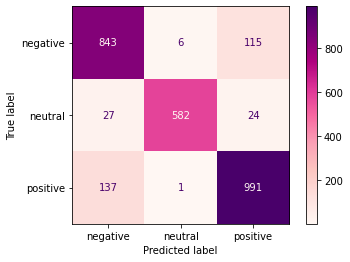

In [ ]:
# Confusion Matrix (newest svm)
disp = ConfusionMatrixDisplay.from_predictions(y_test, model_predict, labels=model.classes_, cmap = "RdPu")

## Save Model

In [ ]:
# save the model to current directory
pickle.dump(model, open('finalized_model.pkl', 'wb'))
# save tfidf vectorizer
pickle.dump(tv, open('vectorizer.pkl', 'wb'))

## Load Model

In [ ]:
# load the model and vectorizer from directory
loaded_model = pickle.load(open('finalized_model.pkl', 'rb'))
loaded_vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

Test prediction

In [ ]:
# function to run prediction on real data
def predict_sentiment(review):
  cleaned_review = clean_text(review)
  tv = loaded_vectorizer
  review_tv = tv.transform([cleaned_review])
  prediction = loaded_model.predict(review_tv)
  prediction = np.array2string(prediction)
  return prediction

In [ ]:
def predict_sentiment_proba(review):
  cleaned_review = clean_text(review)
  tv = loaded_vectorizer
  review_tv = tv.transform([cleaned_review])
  prediction_proba = loaded_model.predict_proba(review_tv) * 100
  prediction_proba = pd.DataFrame(prediction_proba)
  prediction_proba = prediction_proba.transpose()
  return prediction_proba

Predict single review

In [ ]:
test_review = "The customer service is alright"

print("Predicted label: ", predict_sentiment(test_review))
predict_proba_output = predict_sentiment_proba(test_review)
sentiment = ['negative', 'neutral', 'positive']
confidence_df = pd.DataFrame(sentiment, columns = ['sentiment'])
confidence_df = confidence_df.assign(label=predict_proba_output)
confidence_df = confidence_df.rename(columns={confidence_df.columns[1]: 'probability (%)'})
confidence_df

Predicted label:  ['neutral']


,sentiment,probability (%)
0,negative,19.169489
1,neutral,74.638123
2,positive,6.192389


### Batch Prediction for reviews in csv files

In [ ]:
testing_df = pd.read_csv("converse_data_1.csv")

# drop first column
testing_df = testing_df.drop(columns=['Unnamed: 0'])


In [ ]:
# function to run prediction on real data
def predict_sentiment_batch(review):
  label_list = []
  for text in review:
    cleaned_text = clean_text(text)
    tv = loaded_vectorizer
    text_tv = tv.transform([cleaned_text])
    prediction = loaded_model.predict(text_tv)
    label_list.append(prediction)
  output = pd.DataFrame(label_list, columns = ['label'])
  return output

In [ ]:
predict_output = pd.DataFrame(predict_sentiment_batch(list(testing_df['text'])))
testing_df = testing_df.assign(label=predict_output)

testing_df

,text,label
0,"Great integrity, very knowledgeable, skillful ...",positive
1,Horrible customer service! Person on customer ...,negative
2,HORRIBLE CUSTOMER SERVICE AND HONORING DISCOUN...,negative
3,Worst customer service ever ! I submitted a re...,negative
4,Terrible customer service. I have been waiting...,negative
5,The website is horrible. The personal customiz...,negative
6,I saw so many positive reviews about Mrs Olivi...,positive
7,I saw so many positive reviews about Mrs Olivi...,positive
8,"Great service, great result, 100% accuracy vey...",positive
9,You cannot get a hold of customer service at a...,positive


In [ ]:
# export resulting dataframe as csv file
testing_df.to_csv('result.csv', index=False)